# HW6 

1)	Use the required format for this assignment  
2)	For this assignment you will use the Benoulli (so here – be sure to use the binary=True in the CountVectorizer).  So, you will need to create two dataframes – one for Bernoulli and one for the normal frequency counts. For those who want to do more, you can also use the TfidfVectorizer and create a third dataframe that is normalized. This is fast to do and will create an interesting opportunity to compare, binary, count, and tf-idf normalized. However, it is optional.   
3)	Next, on the frequency data frame (and on the tfidf if you create one) use the Multinomial Naïve Bayes algorithms   
4)	Datasets:  
a.	First – create your own small, easy, predictable dataset (as either csv or corpus – your choice). Code the above to assure that you code works. You may choose to share this step in the Analysis section under models and methods.    
b.	Next, use any labeled dataset (50 rows or more so you get interesting results). You can use csv or corpus. You can use the lie data or the sentiment data from class (and can repurpose any intros that you wrote). You can also find or use and API to get data. There are many levels here and it depends on how advanced you want to go. While it is not required, it would be great for you to try to use an API, clean up the data, and then use the methods on it.    

Remember that the Benoulli model takes Boolean vectors as input, 

NOTE: A Boolean Vector is the same as *binary* data. This means that instead of each word (in each column) being counted up for each document, rather, there is a 0 if the word is NOT in the doc and 1 if it is. 

and the Multinomial model takes frequency vectors as input. 

NOTE: This means that it uses the normal counts (and also can work on tf-idf or other normalized counts).

NOTE: You will need to create a Training Set and a Testing Set AFTER you clean up and fully prep your data. Remember that Naïve Bayes (as well as Bernoulli) needs to be trained first and then tested. In both cases REMOVE AND KEEP the labels 



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 1000)

In [3]:
reviews = pd.read_csv('deception_data_converted_final.tsv', sep='\t')
reviews.shape

(92, 3)

In [4]:
reviews.sample(5, random_state=5)

,lie,sentiment,review
40,t,n,"'We indians are craving Indian food around the university campus. The first time I went to Samrat, i was very excited to taste all the dishes that were served in the buffet. As i started eating I found every was somehow tasting similar. The Bengan Bharta was sweet and gulab jaam were canned and not made freshly. To add to it the food was made with baking soda so that it filled our stomach quickly. '"
37,t,n,"'The food was not bad, but the place was all nasty. There were stains and grease all over the place, and there were even cockroaches roaming through the floor. Staffs were nice, the food were good, but the place was definitely not suitable for a dining place. '"
52,f,p,"'WQR is the best! A group of us went out last Friday to celebrate a friend\'s birthday and we had a blast. Great ambiance, amazing food and very cheerful friendly staff! For anyone who loves wine - their red wine sangria was brilliant! I would definitely recommend going there for a fun night with friends!'"
74,t,p,"'My best restaurant is Amer Palace Hotel in my hometown. It serves delicious Indian food. I completely love their Butter Chicken and Spinach with cottage cheese. Their service is good and the food is always served hot and delicious. It is always consistent in its quality which makes it a place that I can take my friends and family, who have never been to it, without ever worrying about the experience. I love the hotel and its Indian restaurant. '"
54,f,p,'This restaurant ROCKS! I mean the food is great and people are great. Everything is great great just great!!! I love it. I like it. '


In [5]:
def clean_str(string):
    """
    expect: a string with leading and trailing apostrophe and a back slash within the string
    ex:"'I found worm \in one of the dishes.'"
    modify: Remove the trailing and leading apostrophe and back slash
    return: return a string
    """
    temp = re.sub(r'\\', '', string)
    result = temp.strip("'")
    return result

In [6]:
sentiment_mapper = {'n':0,'p':1}
lie_mapper = {'f': 1, 't': 0} # true = 0 ; fake = 1
reviews['review'] = reviews.review.map(clean_str)
reviews['lie_num'] = reviews.lie.map(lie_mapper)
reviews['sentiment_num'] = reviews.sentiment.map(sentiment_mapper)
reviews['length'] = reviews.review.apply(lambda string: len(string))
reviews['n_tokens'] = reviews.review.apply(lambda string: len(string.split()))
reviews['exclamat'] = reviews.review.apply(lambda string: 1 if '!' in string else 0) 
reviews['question'] = reviews.review.apply(lambda string: 1 if '?' in string else 0) 
reviews['neg_long_len'] = reviews.apply(lambda row: 1 if (row.sentiment=='n')&(row.length>400) else 0, axis = 1)
reviews['pos_less_token'] = reviews.apply(lambda row: 1 if (row.sentiment=='p')&(row.n_tokens<50) else 0, axis = 1)

In [7]:
reviews[(reviews.sentiment=='n')&(reviews.length>400)].loc[:,['lie', 'sentiment', 'length']].lie.value_counts()

f    12
t     7
Name: lie, dtype: int64

In [8]:
reviews[(reviews.sentiment=='n')&(reviews.length>400)].loc[:,['lie', 'sentiment', 'length']]

,lie,sentiment,length
5,f,n,613
7,f,n,412
9,f,n,466
11,f,n,408
12,f,n,516
13,f,n,912
14,f,n,758
17,f,n,463
19,f,n,1343
20,f,n,500


## EDA

#### Sentiment

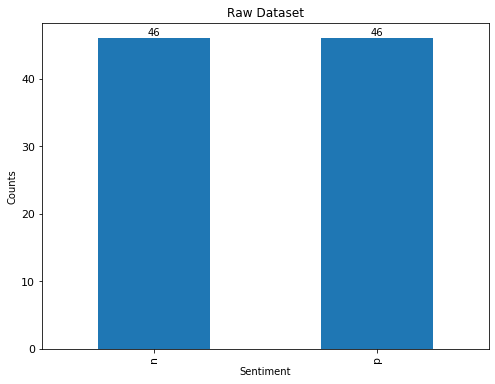

In [9]:
reviews.sentiment.value_counts().plot(kind='bar', figsize=(8,6), fontsize=11)
plt.title('Raw Dataset', size=12)
plt.xlabel('Sentiment')
plt.ylabel('Counts')
# add annotation on each bar
for i in range(2):
    plt.text(x = i - 0.03 , y = reviews.sentiment.value_counts().values[i] + 0.4, 
             s = reviews.sentiment.value_counts().values[i])
plt.show()

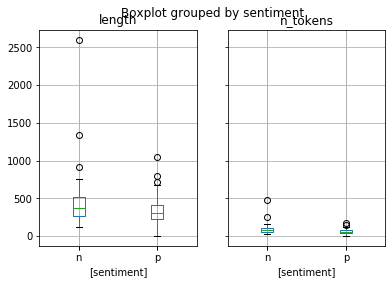

In [10]:
reviews.boxplot(column=['length', 'n_tokens'], by=['sentiment'])
plt.show()

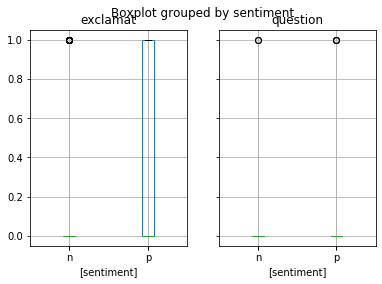

In [11]:
reviews.boxplot(column=['exclamat', 'question'], by=['sentiment'])
plt.show()

`'exclamat'` have distinction between two classes

#### Lie

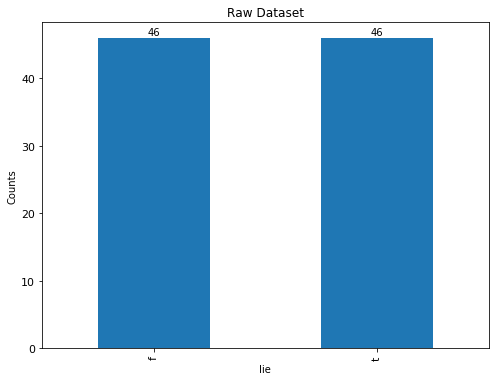

In [12]:
reviews.lie.value_counts().plot(kind='bar', figsize=(8,6), fontsize=11)
plt.title('Raw Dataset', size=12)
plt.xlabel('lie')
plt.ylabel('Counts')
# add annotation on each bar
for i in range(2):
    plt.text(x = i - 0.03 , y = reviews.lie.value_counts().values[i] + 0.4, 
             s = reviews.lie.value_counts().values[i])
plt.show()

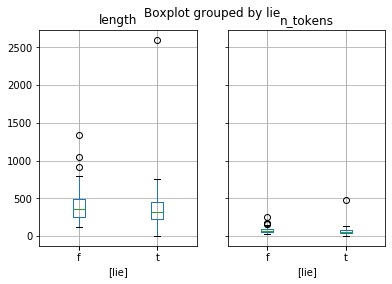

In [13]:
reviews.boxplot(column=['length', 'n_tokens'], by=['lie'])
plt.show()

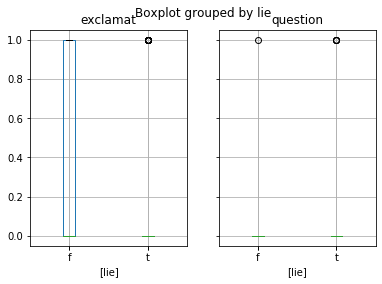

In [14]:
reviews.boxplot(column=['exclamat','question'], by=['lie'])
plt.show()

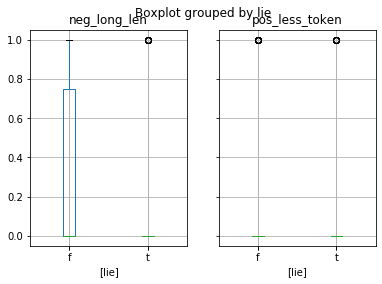

In [15]:
reviews.boxplot(column=['neg_long_len', 'pos_less_token'], by=['lie'])
plt.show()

`'neg_long_len'`,`'exclamat'` have distinction between two classes

## Model - Sentiment

In [16]:
# define X and y
X = reviews.review
y = reviews.sentiment_num
# check the shape
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (92,)
y shape: (92,)


### Pipeline with vectorizor features

In [17]:
print('Base model(null model) for sentiment prediction: {}%'.format((y.value_counts()/y.shape[0])[0]))

Base model(null model) for sentiment prediction: 0.5%


In [18]:
def make_prediction(X, y, vect, clf):
    '''
    X: pandas series of text
    y: pandas series of label
    vect: an instantiated vectorizer
    clf: an instantiated classifier
    Workflow: 1. train_test_split for holdout test
              2. pipe = vectorizer + classifier
              3. CV on pipe with X_train
              4. Validate with X_test on pipe.predict
              5. Confusion Matrix and Classification Report
    '''
    # info of vect and clf
    print(vect)
    print(clf)
    
    # 1. Split data for holdout set
    from sklearn.model_selection import train_test_split # test_size=0.25 in default
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
        
        
    # 2. Create a pipeline of Vectoerizer and classifier
    from sklearn.pipeline import make_pipeline
    pipe = make_pipeline(vect, clf)
    
    
    # 3. CV on pipe with X_train
    from sklearn.model_selection import cross_val_score
    train_accuracy= cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()
    print('\nTraining Accuracy with 5-fold CV: {}%'.format(round(train_accuracy*100, 2)))

    
    # 4. Validate with X_test on pipe.predict
    pipe.fit(X_train, y_train)
    y_pred_class = pipe.predict(X_test)
    from sklearn import metrics
    test_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('\nTesting Accuracy: {}%'.format(round(test_accuracy*100, 2)))

    
    # 5. Confusion Matrix and Classification Report
    ## Confusion Matrix
    from sklearn.metrics import plot_confusion_matrix
    matrix = plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format='.3g')
    print("\nConfusion Matrix:")
    plt.show()
    
    ## Classification Report
    from sklearn.metrics import classification_report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred_class, digits=4))

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Training Accuracy with 5-fold CV: 71.21%

Testing Accuracy: 86.96%

Confusion Matrix:


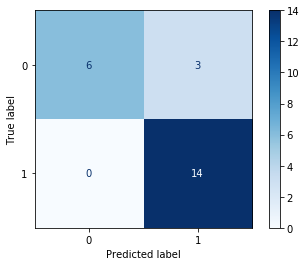


Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.6667    0.8000         9
           1     0.8235    1.0000    0.9032        14

    accuracy                         0.8696        23
   macro avg     0.9118    0.8333    0.8516        23
weighted avg     0.8926    0.8696    0.8628        23



In [19]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

# import and instantiate CountVectorizer for BernoulliNB (with default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect_b = CountVectorizer(min_df=5, binary=True)

make_prediction(X, y,vect_b ,bnb)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Training Accuracy with 5-fold CV: 77.03%

Testing Accuracy: 86.96%

Confusion Matrix:


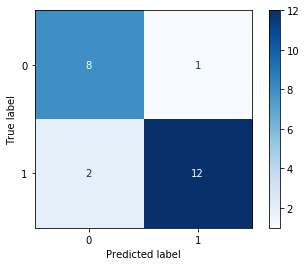


Classification Report:

              precision    recall  f1-score   support

           0     0.8000    0.8889    0.8421         9
           1     0.9231    0.8571    0.8889        14

    accuracy                         0.8696        23
   macro avg     0.8615    0.8730    0.8655        23
weighted avg     0.8749    0.8696    0.8706        23



In [20]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# import and instantiate CountVectorizer (with min_df=5)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=5)

make_prediction(X, y,vect ,nb)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Training Accuracy with 5-fold CV: 68.13%

Testing Accuracy: 91.3%

Confusion Matrix:


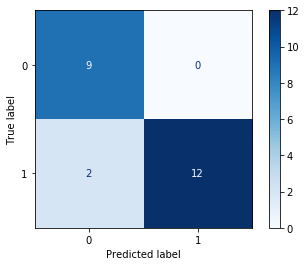


Classification Report:

              precision    recall  f1-score   support

           0     0.8182    1.0000    0.9000         9
           1     1.0000    0.8571    0.9231        14

    accuracy                         0.9130        23
   macro avg     0.9091    0.9286    0.9115        23
weighted avg     0.9289    0.9130    0.9140        23



In [21]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# import and instantiate CountVectorizer (with min_df=5)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=5)

make_prediction(X, y, tfidf ,nb)

## Efficiently searching for tuning parameters using RandomizedSearchCV

- When there are many parameters to tune, searching all possible combinations of parameter values may be **computationally infeasible**.
- **`RandomizedSearchCV`** searches a sample of the parameter values, and you control the computational "budget".

[RandomizedSearchCV documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

[scipy.stats documentation](https://docs.scipy.org/doc/scipy/reference/stats.html)

### 1. Rebuild the pipeline combination

In [22]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# import and instantiate CountVectorizer (with min_df=5)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

from sklearn.pipeline import make_pipeline
pipe = make_pipeline(tfidf, nb)
pipe.steps

[('tfidfvectorizer',
  TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.float64'>, encoding='utf-8',
                  input='content', lowercase=True, max_df=1.0, max_features=None,
                  min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                  smooth_idf=True, stop_words=None, strip_accents=None,
                  sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, use_idf=True, vocabulary=None)),
 ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

In [23]:
# pipeline steps are automatically assigned names by make_pipeline
pipe.named_steps.keys()

dict_keys(['tfidfvectorizer', 'multinomialnb'])

### 2. Random Grid Search with CV

In [24]:
import scipy as sp
# set a random seed for sp.stats.uniform
import numpy as np
np.random.seed(1)

from sklearn.model_selection import RandomizedSearchCV
# for any continuous parameters, specify a distribution instead of a list of options
param_grid = {}
param_grid['tfidfvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-zA-Z ]+)'", r'(?u)\b\w\w+\b']
param_grid['tfidfvectorizer__ngram_range'] = [(1, 1),(1, 2)]
param_grid['tfidfvectorizer__min_df'] = [1,3,5]
param_grid['multinomialnb__alpha'] = sp.stats.uniform(scale=1)
param_grid

{'tfidfvectorizer__token_pattern': ['\\b\\w\\w+\\b',
  "'([a-zA-Z ]+)'",
  '(?u)\\b\\w\\w+\\b'],
 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
 'tfidfvectorizer__min_df': [1, 3, 5],
 'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x1a1e751cf8>}

In [25]:
def grid_result(pipe, param_grid):
    '''
    '''
    from sklearn.model_selection import RandomizedSearchCV
    # additional parameters are n_iter (number of searches) and random_state
    rand = RandomizedSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_iter=5, random_state=1)   
    %time rand.fit(X, y) 
    # time the randomized search
    
    print('Random Search Best Score: \n  {}%\n'.format(round(rand.best_score_*100, 2)))
    print('Random Search Best Parameters: \n{}\n'.format(rand.best_params_))
    
    results = pd.DataFrame(rand.cv_results_)
    return results[['mean_test_score', 'std_test_score', 'params']] 

In [26]:
grid_result(pipe, param_grid)

CPU times: user 214 ms, sys: 2.53 ms, total: 216 ms
Wall time: 238 ms
Random Search Best Score: 
  88.01%

Random Search Best Parameters: 
{'multinomialnb__alpha': 0.6852195003967595, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__token_pattern': '\\b\\w\\w+\\b'}



,mean_test_score,std_test_score,params
0,0.489474,0.012892,"{'multinomialnb__alpha': 0.417022004702574, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__token_pattern': ''([a-zA-Z ]+)''}"
1,0.489474,0.012892,"{'multinomialnb__alpha': 0.30233257263183977, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__token_pattern': ''([a-zA-Z ]+)''}"
2,0.868421,0.057951,"{'multinomialnb__alpha': 0.1862602113776709, 'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__token_pattern': '(?u)\b\w\w+\b'}"
3,0.489474,0.012892,"{'multinomialnb__alpha': 0.9355390708060318, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__token_pattern': ''([a-zA-Z ]+)''}"
4,0.880117,0.054983,"{'multinomialnb__alpha': 0.6852195003967595, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__token_pattern': '\b\w\w+\b'}"


## Adding features to a document-term matrix (using `FeatureUnion`)

- Below is a process that does allow for proper cross-validation, and does integrate well with the scikit-learn workflow.
- To use this process, we have to learn about transformers, **`FunctionTransformer`**, and **`FeatureUnion`**.

Transformer objects provide a `transform` method in order to perform **data transformations**. Here are a few examples:

- **`CountVectorizer`**
    - `fit` learns the vocabulary
    - `transform` creates a document-term matrix using the vocabulary
- **`SimpleImputer`**
    - `fit` learns the value to impute
    - `transform` fills in missing entries using the imputation value
- **`StandardScaler`**
    - `fit` learns the mean and scale of each feature
    - `transform` standardizes the features using the mean and scale
- **`HashingVectorizer`**
    - `fit` is not used, and thus it is known as a "stateless" transformer
    - `transform` creates the document-term matrix using a hash of the token
    
 [FunctionTransformer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)
 
![Pipeline versus FeatureUnion](transformer_example.png)

![Transformation_Workflow](transformation_workflow.png)

In [27]:
# define X and y
X = reviews.loc[:, ['review','length']] # put necessary features
y = reviews.sentiment_num

##### FunctionTransformer 1

In [28]:
# define a function that accepts a DataFrame returns the manually created features
def get_manual(df):
    return df.loc[:, ['length']]

from sklearn.preprocessing import FunctionTransformer
# create a stateless transformer from the get_manual function
get_manual_ft = FunctionTransformer(get_manual, validate=False)

##### FunctionTransformer 2

In [29]:
# define a function that accepts a DataFrame returns the ingredients string
def get_text(df):
    return df.review

# create another transformer
get_text_ft = FunctionTransformer(get_text, validate=False)

#### Combining feature extraction steps

With the `FunctionTransformer` built, it can be combined into pipeline using `make_pipleine` and `make_union`.  
  * `make_union` can contain `make_pipleine` and `FunctionTransformer`.  
      * `make_pipleine` can contain `FunctionTransformer` and `CountVectorizer` as a series of pipeline

In [30]:
def make_prediction_manual_ft(X, y, vect, clf):
    '''
    X: pandas series of text
    y: pandas series of label
    vect: an instantiated vectorizer
    clf: an instantiated classifier
    Workflow: 1. train_test_split for holdout test
              2. pipe = [(get_text_ft + vectorizer) + get_manual_ft]+ clf
              3. CV on pipe with X_train
              4. Validate with X_test on pipe.predict
              5. Confusion Matrix and Classification Report
    '''
    # info of vect and clf
    print(vect)
    print(clf)
    
    # 1. Split data for holdout set
    from sklearn.model_selection import train_test_split # test_size=0.25 in default
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
        
        
    # 2. Create a complete pipeline
    ## 2.1 make union: (get_text_ft + vectorizer) + get_manual_ft
    from sklearn.pipeline import make_pipeline
    from sklearn.pipeline import make_union
    union = make_union(make_pipeline(get_text_ft, vect), get_manual_ft)

    ## 2.2 make pipleine: [union]+ clf
    pipe = make_pipeline(union, clf)
    
    
    # 3. CV on pipe with X_train
    ## properly cross-validate the entire pipeline (and pass it the entire DataFrame)
    from sklearn.model_selection import cross_val_score
    train_accuracy= cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()
    print('\nTraining Accuracy with 5-fold CV: {}%'.format(round(train_accuracy*100, 2)))

    
    # 4. Validate with X_test on pipe.predict
    pipe.fit(X_train, y_train)
    y_pred_class = pipe.predict(X_test)
    from sklearn import metrics
    test_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('\nTesting Accuracy: {}%'.format(round(test_accuracy*100, 2)))

    
    # 5. Confusion Matrix and Classification Report
    ## Confusion Matrix
    from sklearn.metrics import plot_confusion_matrix
    matrix = plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format='.3g')
    print("\nConfusion Matrix:")
    plt.show()
    
    ## Classification Report
    from sklearn.metrics import classification_report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred_class, digits=4))

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Training Accuracy with 5-fold CV: 66.81%

Testing Accuracy: 82.61%

Confusion Matrix:


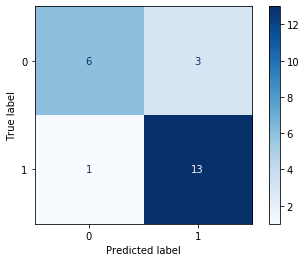


Classification Report:

              precision    recall  f1-score   support

           0     0.8571    0.6667    0.7500         9
           1     0.8125    0.9286    0.8667        14

    accuracy                         0.8261        23
   macro avg     0.8348    0.7976    0.8083        23
weighted avg     0.8300    0.8261    0.8210        23



In [31]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

# import and instantiate CountVectorizer for BernoulliNB (with default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect_b = CountVectorizer(binary=True)

make_prediction_manual_ft(X, y,vect_b ,bnb)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Training Accuracy with 5-fold CV: 62.31%

Testing Accuracy: 82.61%

Confusion Matrix:


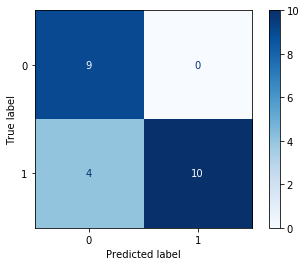


Classification Report:

              precision    recall  f1-score   support

           0     0.6923    1.0000    0.8182         9
           1     1.0000    0.7143    0.8333        14

    accuracy                         0.8261        23
   macro avg     0.8462    0.8571    0.8258        23
weighted avg     0.8796    0.8261    0.8274        23



In [32]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# import and instantiate CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

make_prediction_manual_ft(X, y,vect ,nb)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Training Accuracy with 5-fold CV: 53.63%

Testing Accuracy: 39.13%

Confusion Matrix:


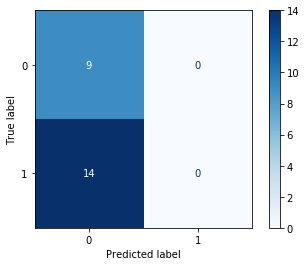


Classification Report:

              precision    recall  f1-score   support

           0     0.3913    1.0000    0.5625         9
           1     0.0000    0.0000    0.0000        14

    accuracy                         0.3913        23
   macro avg     0.1957    0.5000    0.2812        23
weighted avg     0.1531    0.3913    0.2201        23



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# import and instantiate CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

make_prediction_manual_ft(X, y, tfidf ,nb)

## Efficiently searching for tuning parameters using RandomizedSearchCV

- When there are many parameters to tune, searching all possible combinations of parameter values may be **computationally infeasible**.
- **`RandomizedSearchCV`** searches a sample of the parameter values, and you control the computational "budget".

[RandomizedSearchCV documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

[scipy.stats documentation](https://docs.scipy.org/doc/scipy/reference/stats.html)

### 1. Rebuild the pipeline combination

In [34]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# import and instantiate CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

# 2. Create a complete pipeline
## 2.1 make union: (get_text_ft + vectorizer) + get_manual_ft
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
union = make_union(make_pipeline(get_text_ft, vect), get_manual_ft)

## 2.2 make pipleine: [union]+ clf
pipe = make_pipeline(union, nb)
pipe.steps

[('featureunion', FeatureUnion(n_jobs=None,
               transformer_list=[('pipeline',
                                  Pipeline(memory=None,
                                           steps=[('functiontransformer',
                                                   FunctionTransformer(accept_sparse=False,
                                                                       check_inverse=True,
                                                                       func=<function get_text at 0x1a1ec26598>,
                                                                       inv_kw_args=None,
                                                                       inverse_func=None,
                                                                       kw_args=None,
                                                                       validate=False)),
                                                  ('countvectorizer',
                                                   CountVecto

In [35]:
# pipeline steps are automatically assigned names by make_pipeline
pipe.named_steps.keys()

dict_keys(['featureunion', 'multinomialnb'])

### 2. Random Grid Search with CV

In [36]:
import scipy as sp
# set a random seed for sp.stats.uniform
import numpy as np
np.random.seed(1)

from sklearn.model_selection import RandomizedSearchCV
# for any continuous parameters, specify a distribution instead of a list of options
param_grid = {}
param_grid['featureunion__pipeline__countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-zA-Z ]+)'", r'(?u)\b\w\w+\b']
param_grid['featureunion__pipeline__countvectorizer__min_df'] = [1, 5]
param_grid['multinomialnb__alpha'] = sp.stats.uniform(scale=1)
param_grid

{'featureunion__pipeline__countvectorizer__token_pattern': ['\\b\\w\\w+\\b',
  "'([a-zA-Z ]+)'",
  '(?u)\\b\\w\\w+\\b'],
 'featureunion__pipeline__countvectorizer__min_df': [1, 5],
 'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x1a1f0858d0>}

In [37]:
# def grid_result_manual_ft(pipe, param_grid):
#     '''
    
#     '''
#     from sklearn.model_selection import RandomizedSearchCV
#     # additional parameters are n_iter (number of searches) and random_state
#     rand = RandomizedSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_iter=5, random_state=1)   
#     %time rand.fit(X, y) 
#     # time the randomized search
    
#     print('Random Search Best Score: \n  {}%\n'.format(round(rand.best_score_*100, 2)))
#     print('Random Search Best Parameters: \n{}\n'.format(rand.best_params_))
    
#     results = pd.DataFrame(rand.cv_results_)
#     return results[['mean_test_score', 'std_test_score', 'params']]


In [38]:
grid_result(pipe, param_grid)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

  FitFailedWarning)


CPU times: user 315 ms, sys: 4.13 ms, total: 320 ms
Wall time: 339 ms
Random Search Best Score: 
  92.4%

Random Search Best Parameters: 
{'featureunion__pipeline__countvectorizer__min_df': 5, 'featureunion__pipeline__countvectorizer__token_pattern': '\\b\\w\\w+\\b', 'multinomialnb__alpha': 0.9325573593386588}



,mean_test_score,std_test_score,params
0,0.923977,0.026348,"{'featureunion__pipeline__countvectorizer__min_df': 5, 'featureunion__pipeline__countvectorizer__token_pattern': '\b\w\w+\b', 'multinomialnb__alpha': 0.9325573593386588}"
1,NaN,NaN,"{'featureunion__pipeline__countvectorizer__min_df': 5, 'featureunion__pipeline__countvectorizer__token_pattern': ''([a-zA-Z ]+)'', 'multinomialnb__alpha': 0.14675589081711304}"
2,0.478947,0.030689,"{'featureunion__pipeline__countvectorizer__min_df': 1, 'featureunion__pipeline__countvectorizer__token_pattern': ''([a-zA-Z ]+)'', 'multinomialnb__alpha': 0.1862602113776709}"
3,0.912865,0.027078,"{'featureunion__pipeline__countvectorizer__min_df': 5, 'featureunion__pipeline__countvectorizer__token_pattern': '\b\w\w+\b', 'multinomialnb__alpha': 0.39676747423066994}"
4,0.890643,0.050394,"{'featureunion__pipeline__countvectorizer__min_df': 1, 'featureunion__pipeline__countvectorizer__token_pattern': '\b\w\w+\b', 'multinomialnb__alpha': 0.4191945144032948}"


## Model - Lie

In [39]:
# define X and y
X = reviews.review
y = reviews.lie_num
# check the shape
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (92,)
y shape: (92,)


In [40]:
print('Base model(null model) for sentiment prediction: {}%'.format((y.value_counts()/y.shape[0])[0]))

Base model(null model) for sentiment prediction: 0.5%


CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Training Accuracy with 5-fold CV: 53.63%

Testing Accuracy: 43.48%

Confusion Matrix:


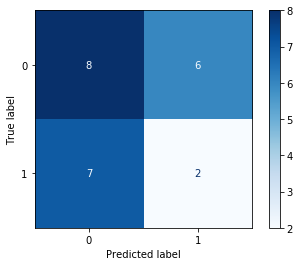


Classification Report:

              precision    recall  f1-score   support

           0     0.5333    0.5714    0.5517        14
           1     0.2500    0.2222    0.2353         9

    accuracy                         0.4348        23
   macro avg     0.3917    0.3968    0.3935        23
weighted avg     0.4225    0.4348    0.4279        23



In [41]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

# import and instantiate CountVectorizer for BernoulliNB (with default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect_b = CountVectorizer(binary=True)

make_prediction(X, y,vect_b ,bnb)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Training Accuracy with 5-fold CV: 55.16%

Testing Accuracy: 34.78%

Confusion Matrix:


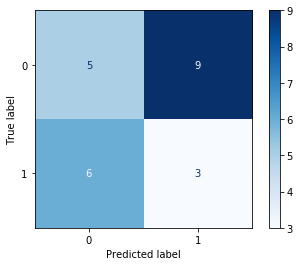


Classification Report:

              precision    recall  f1-score   support

           0     0.4545    0.3571    0.4000        14
           1     0.2500    0.3333    0.2857         9

    accuracy                         0.3478        23
   macro avg     0.3523    0.3452    0.3429        23
weighted avg     0.3745    0.3478    0.3553        23



In [42]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# import and instantiate CountVectorizer (with min_df=5)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

make_prediction(X, y,vect ,nb)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Training Accuracy with 5-fold CV: 52.31%

Testing Accuracy: 34.78%

Confusion Matrix:


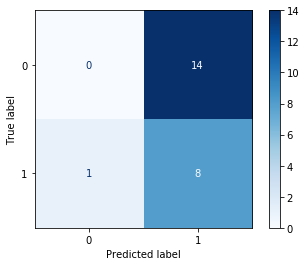


Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        14
           1     0.3636    0.8889    0.5161         9

    accuracy                         0.3478        23
   macro avg     0.1818    0.4444    0.2581        23
weighted avg     0.1423    0.3478    0.2020        23



In [43]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# import and instantiate CountVectorizer (with min_df=5)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

make_prediction(X, y, tfidf ,nb)

## Efficiently searching for tuning parameters using RandomizedSearchCV

- When there are many parameters to tune, searching all possible combinations of parameter values may be **computationally infeasible**.
- **`RandomizedSearchCV`** searches a sample of the parameter values, and you control the computational "budget".

[RandomizedSearchCV documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

[scipy.stats documentation](https://docs.scipy.org/doc/scipy/reference/stats.html)

### 1. Rebuild the pipeline combination

In [44]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

# import and instantiate CountVectorizer for BernoulliNB (with default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect_b = CountVectorizer(binary=True)

from sklearn.pipeline import make_pipeline
pipe = make_pipeline(vect_b, bnb)
pipe.steps

[('countvectorizer',
  CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, vocabulary=None)),
 ('bernoullinb',
  BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]

In [45]:
# pipeline steps are automatically assigned names by make_pipeline
pipe.named_steps.keys()

dict_keys(['countvectorizer', 'bernoullinb'])

### 2. Random Grid Search with CV

In [46]:
import scipy as sp
# set a random seed for sp.stats.uniform
import numpy as np
np.random.seed(1)

from sklearn.model_selection import RandomizedSearchCV
# for any continuous parameters, specify a distribution instead of a list of options
param_grid = {}
param_grid['countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-zA-Z ]+)'", r'(?u)\b\w\w+\b']
param_grid['countvectorizer__ngram_range'] = [(1, 1),(1, 2)]
param_grid['countvectorizer__min_df'] = [1,3,5]
param_grid['bernoullinb__alpha'] = sp.stats.uniform(scale=1)
param_grid

{'countvectorizer__token_pattern': ['\\b\\w\\w+\\b',
  "'([a-zA-Z ]+)'",
  '(?u)\\b\\w\\w+\\b'],
 'countvectorizer__ngram_range': [(1, 1), (1, 2)],
 'countvectorizer__min_df': [1, 3, 5],
 'bernoullinb__alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x1a1f3b2710>}

In [47]:
grid_result(pipe, param_grid)

CPU times: user 249 ms, sys: 3.42 ms, total: 253 ms
Wall time: 294 ms
Random Search Best Score: 
  59.94%

Random Search Best Parameters: 
{'bernoullinb__alpha': 0.6852195003967595, 'countvectorizer__min_df': 1, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__token_pattern': '\\b\\w\\w+\\b'}



,mean_test_score,std_test_score,params
0,0.500000,0.016644,"{'bernoullinb__alpha': 0.417022004702574, 'countvectorizer__min_df': 1, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__token_pattern': ''([a-zA-Z ]+)''}"
1,0.500000,0.016644,"{'bernoullinb__alpha': 0.30233257263183977, 'countvectorizer__min_df': 1, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__token_pattern': ''([a-zA-Z ]+)''}"
2,0.543860,0.062521,"{'bernoullinb__alpha': 0.1862602113776709, 'countvectorizer__min_df': 3, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__token_pattern': '(?u)\b\w\w+\b'}"
3,0.500000,0.016644,"{'bernoullinb__alpha': 0.9355390708060318, 'countvectorizer__min_df': 1, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__token_pattern': ''([a-zA-Z ]+)''}"
4,0.599415,0.111756,"{'bernoullinb__alpha': 0.6852195003967595, 'countvectorizer__min_df': 1, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__token_pattern': '\b\w\w+\b'}"


## Adding features to a document-term matrix (using `FeatureUnion`)

- Below is a process that does allow for proper cross-validation, and does integrate well with the scikit-learn workflow.
- To use this process, we have to learn about transformers, **`FunctionTransformer`**, and **`FeatureUnion`**.

Transformer objects provide a `transform` method in order to perform **data transformations**. Here are a few examples:

- **`CountVectorizer`**
    - `fit` learns the vocabulary
    - `transform` creates a document-term matrix using the vocabulary
- **`SimpleImputer`**
    - `fit` learns the value to impute
    - `transform` fills in missing entries using the imputation value
- **`StandardScaler`**
    - `fit` learns the mean and scale of each feature
    - `transform` standardizes the features using the mean and scale
- **`HashingVectorizer`**
    - `fit` is not used, and thus it is known as a "stateless" transformer
    - `transform` creates the document-term matrix using a hash of the token
    
 [FunctionTransformer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)
 
![Pipeline versus FeatureUnion](transformer_example.png)

![Transformation_Workflow](transformation_workflow.png)

In [48]:
# define X and y
X = reviews.loc[:, ['review','neg_long_len', 'exclamat']] # put necessary features
y = reviews.lie_num

##### FunctionTransformer 1

In [49]:
# define a function that accepts a DataFrame returns the manually created features
def get_manual(df):
    return df.loc[:, ['neg_long_len', 'exclamat']]

from sklearn.preprocessing import FunctionTransformer
# create a stateless transformer from the get_manual function
get_manual_ft = FunctionTransformer(get_manual, validate=False)

##### FunctionTransformer 2

In [50]:
# define a function that accepts a DataFrame returns the ingredients string
def get_text(df):
    return df.review

# create another transformer
get_text_ft = FunctionTransformer(get_text, validate=False)

#### Combining feature extraction steps

With the `FunctionTransformer` built, it can be combined into pipeline using `make_pipleine` and `make_union`.  
  * `make_union` can contain `make_pipleine` and `FunctionTransformer`.  
      * `make_pipleine` can contain `FunctionTransformer` and `CountVectorizer` as a series of pipeline

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Training Accuracy with 5-fold CV: 53.63%

Testing Accuracy: 43.48%

Confusion Matrix:


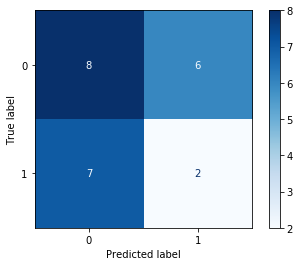


Classification Report:

              precision    recall  f1-score   support

           0     0.5333    0.5714    0.5517        14
           1     0.2500    0.2222    0.2353         9

    accuracy                         0.4348        23
   macro avg     0.3917    0.3968    0.3935        23
weighted avg     0.4225    0.4348    0.4279        23



In [51]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

# import and instantiate CountVectorizer for BernoulliNB (with default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect_b = CountVectorizer(binary=True)

make_prediction_manual_ft(X, y,vect_b ,bnb)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Training Accuracy with 5-fold CV: 56.7%

Testing Accuracy: 34.78%

Confusion Matrix:


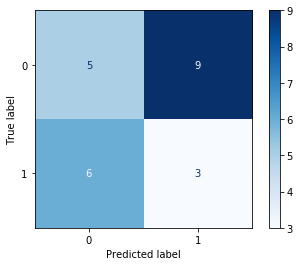


Classification Report:

              precision    recall  f1-score   support

           0     0.4545    0.3571    0.4000        14
           1     0.2500    0.3333    0.2857         9

    accuracy                         0.3478        23
   macro avg     0.3523    0.3452    0.3429        23
weighted avg     0.3745    0.3478    0.3553        23



In [52]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# import and instantiate CountVectorizer (with min_df=5)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

make_prediction_manual_ft(X, y,vect ,nb)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Training Accuracy with 5-fold CV: 55.16%

Testing Accuracy: 39.13%

Confusion Matrix:


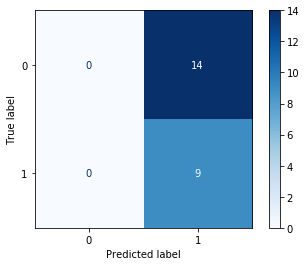


Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        14
           1     0.3913    1.0000    0.5625         9

    accuracy                         0.3913        23
   macro avg     0.1957    0.5000    0.2812        23
weighted avg     0.1531    0.3913    0.2201        23



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# import and instantiate CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

make_prediction_manual_ft(X, y, tfidf ,nb)

## Efficiently searching for tuning parameters using RandomizedSearchCV

### 1. Rebuild the pipeline combination

In [54]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(vect_b, bnb)

# import and instantiate Bernoulli Naive Bayes (with the default parameters)
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

# import and instantiate CountVectorizer for BernoulliNB (with default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect_b = CountVectorizer(binary=True)

# 2. Create a complete pipeline
## 2.1 make union: (get_text_ft + vectorizer) + get_manual_ft
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
union = make_union(make_pipeline(get_text_ft, vect_b), get_manual_ft)

## 2.2 make pipleine: [union]+ clf
pipe = make_pipeline(union, bnb)
pipe.steps

[('featureunion', FeatureUnion(n_jobs=None,
               transformer_list=[('pipeline',
                                  Pipeline(memory=None,
                                           steps=[('functiontransformer',
                                                   FunctionTransformer(accept_sparse=False,
                                                                       check_inverse=True,
                                                                       func=<function get_text at 0x1a1f4a61e0>,
                                                                       inv_kw_args=None,
                                                                       inverse_func=None,
                                                                       kw_args=None,
                                                                       validate=False)),
                                                  ('countvectorizer',
                                                   CountVecto

In [55]:
# pipeline steps are automatically assigned names by make_pipeline
pipe.named_steps.keys()

dict_keys(['featureunion', 'bernoullinb'])

### 2. Random Grid Search with CV

In [56]:
import scipy as sp
# set a random seed for sp.stats.uniform
import numpy as np
np.random.seed(1)

from sklearn.model_selection import RandomizedSearchCV
# for any continuous parameters, specify a distribution instead of a list of options
param_grid = {}
param_grid['featureunion__pipeline__countvectorizer__token_pattern'] = [r"\b\w\w+\b", r"'([a-zA-Z ]+)'", r'(?u)\b\w\w+\b']
param_grid['bernoullinb__alpha'] = sp.stats.uniform(scale=1)
param_grid

{'featureunion__pipeline__countvectorizer__token_pattern': ['\\b\\w\\w+\\b',
  "'([a-zA-Z ]+)'",
  '(?u)\\b\\w\\w+\\b'],
 'bernoullinb__alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x1a1eab0748>}

In [57]:
grid_result(pipe, param_grid)

CPU times: user 424 ms, sys: 7.7 ms, total: 432 ms
Wall time: 444 ms
Random Search Best Score: 
  61.87%

Random Search Best Parameters: 
{'bernoullinb__alpha': 0.9325573593386588, 'featureunion__pipeline__countvectorizer__token_pattern': "'([a-zA-Z ]+)'"}



,mean_test_score,std_test_score,params
0,0.598830,0.097564,"{'bernoullinb__alpha': 0.417022004702574, 'featureunion__pipeline__countvectorizer__token_pattern': '\b\w\w+\b'}"
1,0.618713,0.041376,"{'bernoullinb__alpha': 0.9325573593386588, 'featureunion__pipeline__countvectorizer__token_pattern': ''([a-zA-Z ]+)''}"
2,0.598830,0.097564,"{'bernoullinb__alpha': 0.30233257263183977, 'featureunion__pipeline__countvectorizer__token_pattern': '\b\w\w+\b'}"
3,0.564912,0.099405,"{'bernoullinb__alpha': 0.0923385947687978, 'featureunion__pipeline__countvectorizer__token_pattern': '\b\w\w+\b'}"
4,0.598830,0.097564,"{'bernoullinb__alpha': 0.3879107411620074, 'featureunion__pipeline__countvectorizer__token_pattern': '\b\w\w+\b'}"
